# Analysis of corpus files

## Import directives

In [62]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


## Common components

We need a generator class to iterate over the files:

In [63]:
class Corpus:
    def __init__(self, corpus_dir):
        self._corpus_dir = corpus_dir

    def __iter__(self):
        for file_name in self._get_file_names():
            try:
                yield self._get_file_text(file_name)
            except json.decoder.JSONDecodeError:
                continue
            except TypeError:
                continue

    def _get_file_names(self):
        for root, dirs, files in os.walk(self._corpus_dir):
            for f in files:
                yield os.path.join(root, f)

    def _get_file_text(self, file_name):
        text = []
        with open(file_name, 'rt') as f:
            data = json.load(f)
            for section in data['body']:
                text.append(section['title'])
                text.append(section['text'])
            return '\n'.join(text)


### Plotting utils

We need a method to transform topic distribution matrix into data points which can be plotted:

In [64]:
def get_data_points(topic_distribution, cutoff=0.4):
    x, y, z = [], [], []
    for (doc_ix, topic_ix), prob in np.ndenumerate(topic_distribution):
        if prob > cutoff:
            x.append(topic_ix)
            z.append(doc_ix)
            y.append(prob)
    return np.asarray(x), np.asarray(y), np.asarray(z)

And a method to actually plot the data:

In [65]:
def plot_data_points(x, y, z=0):
    plt.cla()
    plt.clf()
    if not isinstance(z, np.ndarray):
        plt.scatter(x, y)
    else:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z)
        ax.set_xlabel('Topic')
        ax.set_ylabel('Probability')
        ax.set_zlabel('Document')
    plt.show()


Finally we need to know the path to the corpus:

In [66]:
corpus_dir = input('Corpus directory:')

Corpus directory:/home/petru/Downloads/metis-in/train


## Truncated Singular Value Decomposition on Bag of Words

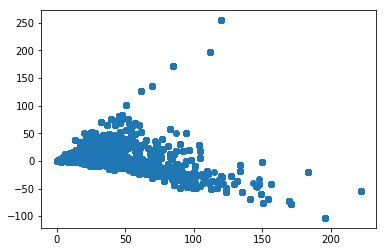

In [67]:
corpus = Corpus(corpus_dir)

count_vectorizer = CountVectorizer(stop_words='english')
bow = count_vectorizer.fit_transform(corpus)

t_svd = TruncatedSVD()
t_svd.fit(bow)
bow = t_svd.transform(bow)
x, y = ([_x for _x, _y in bow], [_y for _x, _y in bow])

plot_data_points(x, y)


## Truncated Singular Value Decomposition on TF-IDF

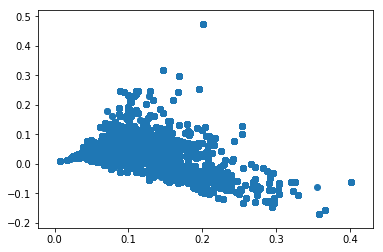

In [68]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(corpus)

tfidf_tsvd = t_svd.transform(tfidf)
x, y = ([_x for _x, _y in tfidf_tsvd], [_y for _x, _y in tfidf_tsvd])
plot_data_points(x, y)


## Document to topic distribution using Latent Dirichlet Allocation on TF-IDF

Running `Latent Dirichlet Allocation` with 150 clusters as per the results of [running Hierarchical Dirichlet Process analysis](../analysis/hdp.py).

In [69]:
num_topics = 150

<Figure size 432x288 with 0 Axes>

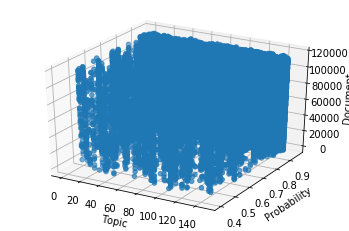

In [70]:
tfidf_lda = LatentDirichletAllocation(n_components=num_topics, learning_method='batch')
tfidf_distrib = tfidf_lda.fit_transform(tfidf)

x, y, z = get_data_points(tfidf_distrib)

plot_data_points(x, y, z)


## Document to topic distribution using Latent Dirichlet Allocation on Bag of Words

The negative values from `Bag of Words` need to be clipped in order to have a proper `Latent Dirichlet Allocation` model.

<Figure size 432x288 with 0 Axes>

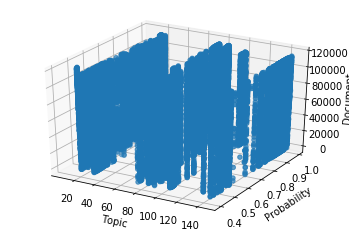

In [71]:
bow = bow.clip(min=0)

bow_lda = LatentDirichletAllocation(n_components=num_topics, learning_method='batch')
bow_distrib = bow_lda.fit_transform(bow)

x, y, z = get_data_points(bow_distrib)

plot_data_points(x, y, z)


## Number of documents per LDA topic

In [72]:
def get_documents_per_topic(topic_distribution, cutoff=0.4):
    num_docs, num_topics = topic_distribution.shape
    x, y = [], []
    for topic in range(num_topics):
        docs = topic_distribution[:, topic]
        num_docs = (docs > cutoff).sum()
        if num_docs > 0:
            x.append(topic)
            y.append(num_docs)
    return np.asarray(x), np.asarray(y)


In [73]:
def plot_documents_per_topic(x, y):
    plt.cla()
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x, y)
    ax.set_xlabel('Topic')
    ax.set_ylabel('Num documents')
    plt.show()


### TF-IDF

<Figure size 432x288 with 0 Axes>

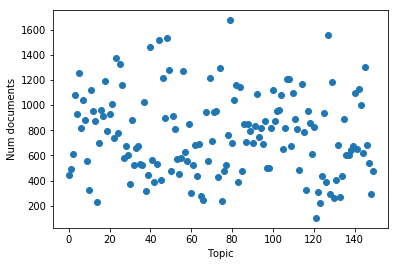

In [74]:
x, y = get_documents_per_topic(tfidf_distrib)
plot_documents_per_topic(x, y)


### Bag of Words

<Figure size 432x288 with 0 Axes>

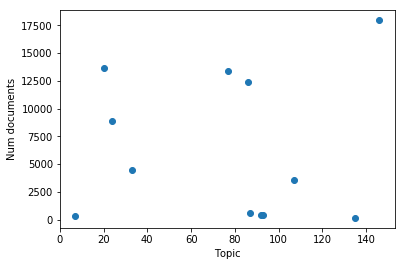

In [75]:
x, y = get_documents_per_topic(bow_distrib)
plot_documents_per_topic(x, y)
